<a href="https://colab.research.google.com/github/TakshayBansal/RLforTrading/blob/main/RL_Trading_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import yfinance as yf
import pandas as pd

In [ ]:
!pip install yfinance


In [ ]:
tickers = [
    "ADANIENT.NS", "ADANIGREEN.NS", "ADANIPORTS.NS", "AMBUJACEM.NS", "ASIANPAINT.NS",
    "AXISBANK.NS", "BAJAJ-AUTO.NS", "BAJAJFINSV.NS", "BAJFINANCE.NS", "BHARTIARTL.NS",
    "BPCL.NS", "BRITANNIA.NS", "CIPLA.NS", "COALINDIA.NS", "DIVISLAB.NS",
    "DRREDDY.NS", "EICHERMOT.NS", "GRASIM.NS", "HCLTECH.NS", "HDFC.NS",
    "HDFCBANK.NS", "HDFCLIFE.NS", "HEROMOTOCO.NS", "HINDALCO.NS", "HINDUNILVR.NS",
    "ICICIBANK.NS", "INDUSINDBK.NS", "INFY.NS", "ITC.NS", "JSWSTEEL.NS",
    "KOTAKBANK.NS", "LT.NS", "M&M.NS", "MARUTI.NS", "NTPC.NS",
    "ONGC.NS", "POWERGRID.NS", "RELIANCE.NS", "SBILIFE.NS", "SBIN.NS",
    "SUNPHARMA.NS", "TATACONSUM.NS", "TATAMOTORS.NS", "TATASTEEL.NS", "TCS.NS",
    "TECHM.NS", "TITAN.NS", "ULTRACEMCO.NS", "UPL.NS", "WIPRO.NS"
]

def get_data(tickers):
  data = {}
  for ticker in tickers:
    data[ticker] = yf.download(ticker, start = "2007-01-01", end = "2024-11-01")
  return data

stock_data = get_data(tickers)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
def preprocess_data(data):
  data.reset_index(inplace=True)
  data.columns = [''.join(col) for col in data.columns.values]
  new_cols = []
  for col in data.columns:
    new_col = col.replace(ticker, '').strip()
    new_cols.append(new_col)
  data.columns = new_cols
  data['Date'] = pd.to_datetime(data['Date'])
  data['Date'] = data['Date'].dt.date

  return data

In [ ]:
for ticker, df in stock_data.items():
  stock_data[ticker] = preprocess_data(df)
  stock_data[ticker].to_csv(f"{ticker}.csv")

In [ ]:
import pandas as pd

benchmark = "^NSEI"
benchmark_data = yf.download(benchmark, start = "2009-01-01", end = "2024-11-30")
benchmark_data = preprocess_data(benchmark_data)
benchmark_data.to_csv(f"{benchmark}.csv")

stock_data = {}
for ticker in tickers:
  stock_data[ticker] = pd.read_csv(f"{ticker}.csv", index_col = 'Date', parse_dates = True)

training_range = ('2009-01-01', '2021-12-31')
validation_range = ('2022-01-01', '2022-12-31')
testing_range = ('2023-01-01', '2025-03-01')

training_data = {}
validation_data = {}
testing_data = {}

for ticker, df in stock_data.items():
  training_data[ticker] = df.loc[training_range[0]:training_range[1]]
  validation_data[ticker] = df.loc[validation_range[0]:validation_range[1]]
  testing_data[ticker] = df.loc[testing_range[0]:testing_range[1]]


[*********************100%***********************]  1 of 1 completed


In [ ]:
import numpy as np

def add_technical_indicator(df):
  #Calculate 14-period RSI
  delta = df['Close'].diff()
  up = delta.clip(lower=0)
  down = -1 * delta.clip(upper=0)
  ema_up = up.ewm(com=13, adjust=False).mean()
  ema_down = down.ewm(com=13, adjust=False).mean()
  rs = ema_up / ema_down
  df['RSI'] = 100 - (100 / (1 + rs))

  #Calculate 12 and 26 period EMAs for MACD
  df.loc[:,'EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
  df.loc[:,'EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
  df.loc[:,'MACD'] = df['EMA12'] - df['EMA26']
  df.loc[:,'Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

  #Calculate 20-period CCI
  tp = (df['High'] + df['Low'] + df['Close']) / 3
  sma = tp.rolling(window=20).mean()
  mad = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - np.mean(x))))
  df.loc[:,'CCI'] = (tp - sma) / (0.015 * mad)

  #Calculate 14-period ADX
  high_diff = df['High'].diff()
  low_diff = df['Low'].diff()
  df.loc[:,'+DM'] = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
  df.loc[:,'-DM'] = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
  tr =pd.concat([df['High'] - df['Low'],np.abs(df['High'] - df['Close'].shift(1)), np.abs(df['Low']-df['Close'].shift(1))],axis = 1).max(axis =1)
  atr = tr.ewm(span=14, adjust=False).mean()
  df.loc[:,'+DI'] = 100 * (df['+DM'].ewm(span=14, adjust=False).mean() / atr)
  df.loc[:,'-DI'] = 100 * (df['-DM'].ewm(span=14, adjust=False).mean() / atr)
  dx = 100 * abs((df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI']))
  df.loc[:,'ADX'] = dx.ewm(span=14, adjust=False).mean()

  df.dropna(inplace=True)

  return df

In [ ]:
for ticker, df in training_data.items():
  training_data[ticker] = add_technical_indicator(df)

for ticker, df in validation_data.items():
  validation_data[ticker] = add_technical_indicator(df)

for ticker, df in testing_data.items():
  testing_data[ticker] = add_technical_indicator(df)

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'-DM'] = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
<ipython-input-7-f2d59f0ee382>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'+DI'] = 100 * (df['+DM'].ewm(span=14, adjust=False).mean() / atr)
<ipython-input-7-f2d59f0ee382>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

In [ ]:
!pip install gymnasium

In [ ]:
import gymnasium as gym
from gymnasium import spaces

class StockTradingEnv(gym.Env):
  metadata = {'render_modes' : ['human']}

  def __init__(self, stock_data, transaction_cost_percent = 0.005):
    super(StockTradingEnv, self).__init__()

    self.stock_data = {ticker: df for ticker, df in stock_data.items() if not df.empty}
    self.tickers = list(self.stock_data.keys())

    if not self.tickers:
      raise ValueError("No valid stock data available.")

    #Calculate the size of one stock's data
    sample_df = next(iter(self.stock_data.values()))
    self.n_features = len(sample_df.columns)

    #Define action and observation spaces
    self.action_space = spaces.Box(low = -1, high = 1, shape = (len(self.tickers),),dtype=np.float32)

    self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
    self.observation_space = spaces.Box(low = -np.inf, high = np.inf, shape = (self.obs_shape,), dtype = np.float32)

    #Set the Account Balance

    self.initial_balance = 100000
    self.balance = self.initial_balance
    self.net_worth = self.initial_balance
    self.max_net_worth = self.initial_balance

    self.shares_held = {ticker: 0 for ticker in self.tickers}
    self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
    self.total_sales_value = {ticker: 0 for ticker in self.tickers}

    #Set current step and transaction cost
    self.current_step = 0
    self.transaction_cost_percent = transaction_cost_percent

    #calculate the min lenth of data across all stocks
    self.max_steps = max(0, min(len(df) for df in self.stock_data.values())-1)
    #self.isactive = True

  def reset(self,seed = None, options = None):
    super().reset(seed = seed)
    self.balance = self.initial_balance
    self.net_worth = self.initial_balance
    self.max_net_worth = self.initial_balance
    self.shares_held = {ticker: 0 for ticker in self.tickers}
    self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
    self.total_sales_value = {ticker: 0 for ticker in self.tickers}
    self.current_step = 0
    #self.isactive = False
    return self._next_observation(), {}

  def _next_observation(self):

    frame = np.zeros(self.obs_shape)

    idx = 0

    for ticker in self.tickers:
      df = self.stock_data[ticker]

      if self.current_step < len(df) :
        frame[idx:idx+self.n_features] = df.iloc[self.current_step].values
      elif len(df) > 0:
        frame[idx:idx+self.n_features] = df.iloc[-1].values

      idx += self.n_features

    frame[-4-len(self.tickers)] = self.balance
    frame[-3-len(self.tickers):-3] = [self.shares_held[ticker] for ticker in self.tickers]
    frame[-3] = self.net_worth
    frame[-2] = self.max_net_worth
    frame[-1] = self.current_step
    return frame

  def step(self, actions):
    self.current_step += 1

    if self.current_step > self.max_steps:
      return self._next_observation(), 0, True,False, {}

    # if not self.isactive:
    #   return self._next_observation(), 0, True,False, {}

    current_prices = {}

    for i, ticker in enumerate(self.tickers):
      current_prices[ticker] = self.stock_data[ticker].iloc[self.current_step]['Close']
      action = actions[i]

      if action > 0: #Buy
        shares_to_buy = int(self.balance / current_prices[ticker])
        self.shares_held[ticker] += shares_to_buy
        cost = shares_to_buy * current_prices[ticker]
        transaction_cost = cost * self.transaction_cost_percent
        self.balance -= (cost + transaction_cost)
      elif action < 0: #Sell
        shares_to_sell = int(self.shares_held[ticker] * abs(action))
        sale = shares_to_sell * current_prices[ticker]
        transaction_cost = sale * self.transaction_cost_percent
        self.balance += (sale - transaction_cost)
        self.shares_held[ticker] -= shares_to_sell

        self.total_shares_sold[ticker] += shares_to_sell
        self.total_sales_value[ticker] += sale

    self.net_worth = self.balance + sum(self.shares_held[ticker] * current_prices[ticker] for ticker in self.tickers)
    self.max_net_worth = max(self.max_net_worth, self.net_worth)

    reward = (self.net_worth - self.initial_balance)
    done = self.net_worth <=0 or self.current_step >= self.max_steps

    return self._next_observation(), reward, done, False, {}

  def render(self, mode = 'human'):
    profit = self.net_worth - self.initial_balance
    print(f"Step: {self.current_step}")
    print(f"Balance: {self.balance}")
    for ticker in self.tickers:
      print(f"{ticker} Shares held : {self.shares_held[ticker]}")
    print(f"Net Worth: {self.net_worth}")
    print(f"Profit: {profit}")

  def close(self):
    pass


In [ ]:
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv

class EnsembleAgent:
  def __init__(self, ppo_model, a2c_model, ddpg_model, sac_model, td3_model):
    self.ppo_model = ppo_model
    self.a2c_model = a2c_model
    self.ddpg_model = ddpg_model
    self.sac_model = sac_model
    self.td3_model = td3_model

  def predict(self, obs):
    ppo_action, _ = self.ppo_model.predict(obs)
    a2c_action, _ = self.a2c_model.predict(obs)
    ddpg_action, _ = self.ddpg_model.predict(obs)
    sac_action, _ = self.sac_model.predict(obs)
    td3_action, _ = self.td3_model.predict(obs)

    ensemble_action = np.mean([ppo_action, a2c_action, ddpg_action, sac_action, td3_action], axis = 0)
    return ensemble_action

In [ ]:
class PPOAgent:
  def __init__(self, env, total_timesteps):
    self.model = PPO("MlpPolicy",env,verbose = 1)
    self.model.learn(total_timesteps = total_timesteps)

  def predict(self, obs):
    action, _ = self.model.predict(obs)
    return action

class A2CAgent:
  def __init__(self, env, total_timesteps):
    self.model = A2C("MlpPolicy",env,verbose = 1)
    self.model.learn(total_timesteps = total_timesteps)

  def predict(self, obs):
    action, _ = self.model.predict(obs)
    return action

class DDPGAgent:
  def __init__(self, env, total_timesteps):
    self.model = DDPG("MlpPolicy",env,verbose = 1)
    self.model.learn(total_timesteps = total_timesteps)

  def predict(self, obs):
    action, _ = self.model.predict(obs)
    return action

class SACAgent:
  def __init__(self, env, total_timesteps):
    self.model = SAC("MlpPolicy",env,verbose = 1)
    self.model.learn(total_timesteps = total_timesteps)

  def predict(self, obs):
    action, _ = self.model.predict(obs)
    return action

class TD3Agent:
  def __init__(self, env, total_timesteps):
    self.model = TD3("MlpPolicy",env,verbose = 1)
    self.model.learn(total_timesteps = total_timesteps)

  def predict(self, obs):
    action, _ = self.model.predict(obs)
    return action

In [ ]:
import matplotlib.pyplot as plt

def create_env_and_train_agents(data, total_timesteps):

  def make_env():
    return StockTradingEnv(stock_data = data)
  env = DummyVecEnv([make_env])

  ppo_agent = PPOAgent(env, total_timesteps)
  a2c_agent = A2CAgent(env, total_timesteps)
  ddpg_agent = DDPGAgent(env, total_timesteps)
  sac_agent = SACAgent(env, total_timesteps)
  td3_agent = TD3Agent(env, total_timesteps)

  ensemble_agent = EnsembleAgent(ppo_agent.model, a2c_agent.model, ddpg_agent.model, sac_agent.model, td3_agent.model)

  return env, ppo_agent, a2c_agent, ddpg_agent, sac_agent, td3_agent, ensemble_agent

In [ ]:
def visualize_potfolio(steps, balances, net_worths, shares_held, tickers, show_balance = True, show_net_worth = True, show_shares_held = True):
  fig, axs = plt.subplots(3, figsize = (12,18))

  if show_balance:
    axs[0].plot(steps, balances, label = "Balance")
    axs[0].title('Balance Over Time')
    axs[0].xlabel('Steps')
    axs[0].ylabel('Balance')
    axs[0].legend()

  if show_net_worth:
    axs[1].plot(steps, balances, label = "Net Worth", color = 'orange')
    axs[1].title('Net Worth Over Time')
    axs[1].xlabel('Steps')
    axs[1].ylabel('Net Worth')
    axs[1].legend()

  if show_shares_held:
    for i, ticker in enumerate(tickers):
      axs[2].plot(steps, shares_held[ticker], label = f"Shres held : {ticker}")
    axs[2].title('Shares Held Over Time')
    axs[2].xlabel('Steps')
    axs[2].ylabel('Shares Held')
    axs[2].legend()

  plt.tight_layout()
  plt.show()


In [ ]:
def visualize_potfolio_net_worth(steps, net_worths):
  plt.figure(figsize = (12,6))
  plt.plot(steps, balances, label = "Net Worth", color = 'orange')
  plt.title('Net Worth Over Time')
  plt.xlabel('Steps')
  plt.ylabel('Net Worth')
  plt.legend()

def visualize_multiple_portfolio_net_worth(steps, net_worths_list, labels):
  plt.figure(figsize = (12,6))
  for i, net_worths in enumerate(net_worths_list):
    plt.plot(steps, net_worths, label = labels[i])
  plt.title('Net Worth Over Time')
  plt.xlabel('Steps')
  plt.ylabel('Net Worth')
  plt.legend()

In [ ]:
def test_agent(env, agent, stock_data, n_tests = 800, visualize = False):
  metrics = {
      'steps': [],
      'balances':[],
      'net_worths': [],
      'shares_held': {ticker: [] for ticker in stock_data.keys()},
  }

  obs = env.reset()

  for i in range(n_tests):
    metrics['steps'].append(i)
    action = agent.predict(obs)

    obs, rewards, dones, infos = env.step(action)
    if visualize:
      env.render()

    metrics['balances'].append(env.get_attr('balance')[0])
    metrics['net_worths'].append(env.get_attr('net_worth')[0])

    env_shares_held = env.get_attr('shares_held')[0]

    for ticker in stock_data.keys():
      if ticker in env_shares_held:
        metrics['shares_held'][ticker].append(env_shares_held[ticker])
      else:
        metrics['shares_held'][ticker].append(0)
    if dones:
      obs = env.reset()

  return metrics

In [ ]:
def test_and_visualize_agents(env, agents, training_data, n_tests = 800):
  metrics = {}
  for agent_name, agent in agents.items():
    print(f"Testing {agent_name}...")
    metrics[agent_name] = test_agent(env, agent, training_data, n_tests = n_tests, visualize = True)
    print(f"Done Testing {agent_name}!")


  print('-'*50)
  print("All Agents Tested!!")
  print('-'*50)

  net_worths = [metrics[agent_name]['net_worths'] for agent_name in agents.keys()]
  steps = next(iter(metrics.values()))['steps']

  visualize_multiple_portfolio_net_worth(steps, net_worths, list(agents.keys()))
  return metrics

In [ ]:
# def compare_and_plot_agents(agents_metrics, labels, risk_free_rate = 0.0):
#   def compare_agents(agents_metrics, labels):
#     returns = []
#     stds = []
#     sharpe_ratios = []

#     for metrics in agents_metrics:
#       net_worths = metrics['net_worths']

#       daily_returns = np.diff(net_worths)/net_worths[:-1]
#       avg_return = np.mean(daily_returns)
#       std_return = np.std(daily_returns)
#       sharpe_ratio = (avg_return - risk_free_rate)/std_return

#       returns.append(avg_return * 100)
#       stds.append(std_return)
#       sharpe_ratios.append(sharpe_ratio)

#     df = pd.DataFrame({
#         'Agent' : labels,
#         'Daily Returns (%)' : returns,
#         'Standard Deviation' : stds,
#         'Sharpe Ratio' : sharpe_ratios
#     })

#     return df

#   df = compare_agents(agents_metrics, labels)

#   df_sorted = df.sort_values(by = 'Sharpe Ratio', ascending = False)

#   display(df_sorted)

#   plt.figure(figsize = (12,6))
#   plt.bar(df_sorted['Agent'], df_sorted['Sharpe Ratio'])
#   plt.xlabel('Agent')
#   plt.ylabel('Sharpe Ratio')
#   plt.title('Sharpe Ratio Comparison')
#   plt.show()
def compare_and_plot_agents_with_returns(agents_metrics, labels, risk_free_rate=0.0):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    returns = []
    stds = []
    sharpe_ratios = []
    daily_returns_all = []
    net_worths_all = []

    for i, metrics in enumerate(agents_metrics):
        net_worths = metrics['net_worths']
        net_worths_all.append(net_worths)

        daily_returns = np.diff(net_worths) / net_worths[:-1]
        daily_returns_all.append(daily_returns)

        avg_return = np.mean(daily_returns)
        std_return = np.std(daily_returns)
        sharpe_ratio = (avg_return - risk_free_rate) / std_return

        returns.append(avg_return * 100)  # Daily return in %
        stds.append(std_return)
        sharpe_ratios.append(sharpe_ratio)

    # Build dataframe for tabular comparison
    df = pd.DataFrame({
        'Agent': labels,
        'Daily Returns (%)': returns,
        'Standard Deviation': stds,
        'Sharpe Ratio': sharpe_ratios
    })

    df_sorted = df.sort_values(by='Sharpe Ratio', ascending=False)

    # Display metrics
    display(df_sorted)

    # ------------------ Plot 1: Sharpe Ratio Bar Plot ------------------
    plt.figure(figsize=(10, 5))
    plt.bar(df_sorted['Agent'], df_sorted['Sharpe Ratio'], color='darkcyan')
    plt.title('Sharpe Ratio Comparison')
    plt.xlabel('Agent')
    plt.ylabel('Sharpe Ratio')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # ------------------ Plot 2: Net Worth Over Time ------------------
    plt.figure(figsize=(12, 6))
    for net_worth, label in zip(net_worths_all, labels):
        plt.plot(net_worth, label=label)
    plt.title('Portfolio Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.bar(df_sorted['Agent'], df_sorted['Daily Returns (%)'], color='darkcyan')
    plt.title('Daily Returns Comparison')
    plt.xlabel('Agent')
    plt.ylabel('Returns')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for returns, label in zip(daily_returns_all, labels):
        plt.plot(returns, label=label)
    plt.title("Daily Returns Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Daily Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ------------------ Plot 5: Scatter Plot of Daily Returns ------------------
    plt.figure(figsize=(12, 6))
    for i, (returns, label) in enumerate(zip(daily_returns_all, labels)):
        plt.scatter(range(len(returns)), returns, label=label, alpha=0.6, s=10)
    plt.title("Scatter Plot of Daily Returns")
    plt.xlabel("Time Step")
    plt.ylabel("Daily Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [ ]:
#test_and_visualize_agents(env, agents, training_data, n_tests=800)


In [ ]:
total_timesteps = 5000
env, ppo_agent, a2c_agent, ddpg_agent, sac_agent, td3_agent, ensemble_agent = create_env_and_train_agents(training_data, total_timesteps)

n_tests = 800
agents = {
    'PPOAgent': ppo_agent,
    'A2CAgent': a2c_agent,
    'DDPGAgent': ddpg_agent,
    'SACAgent': sac_agent,
    'TD3Agent': td3_agent,
    'EnsembleAgent' : ensemble_agent
}



Using cpu device
-----------------------------
| time/              |      |
|    fps             | 91   |
|    iterations      | 1    |
|    time_elapsed    | 22   |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 91            |
|    iterations           | 2             |
|    time_elapsed         | 44            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 9.4633055e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -69.5         |
|    explained_variance   | 9.54e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 2.36e+11      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00167      |
|    std                  | 1             |
|    value_loss          

Testing PPOAgent...
Testing PPOAgent...


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/base_vec_env.py:259: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/base_vec_env.py:259: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Done Testing PPOAgent!
Testing A2CAgent...
Done Testing PPOAgent!
Testing A2CAgent...
Done Testing A2CAgent!
Testing DDPGAgent...
Done Testing A2CAgent!
Testing DDPGAgent...
Done Testing DDPGAgent!
Testing SACAgent...
Done Testing DDPGAgent!
Testing SACAgent...
Done Testing SACAgent!
Testing TD3Agent...
Done Testing SACAgent!
Testing TD3Agent...
Done Testing TD3Agent!
Testing EnsembleAgent...
Done Testing TD3Agent!
Testing EnsembleAgent...
Done Testing EnsembleAgent!
--------------------------------------------------
All Agents Tested!!
--------------------------------------------------
Done Testing EnsembleAgent!
--------------------------------------------------
All Agents Tested!!
--------------------------------------------------


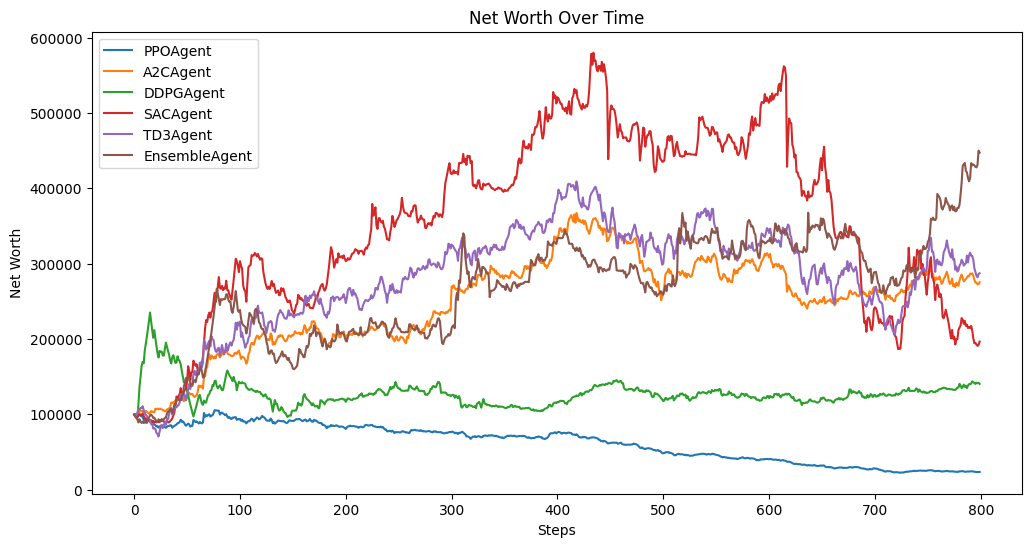

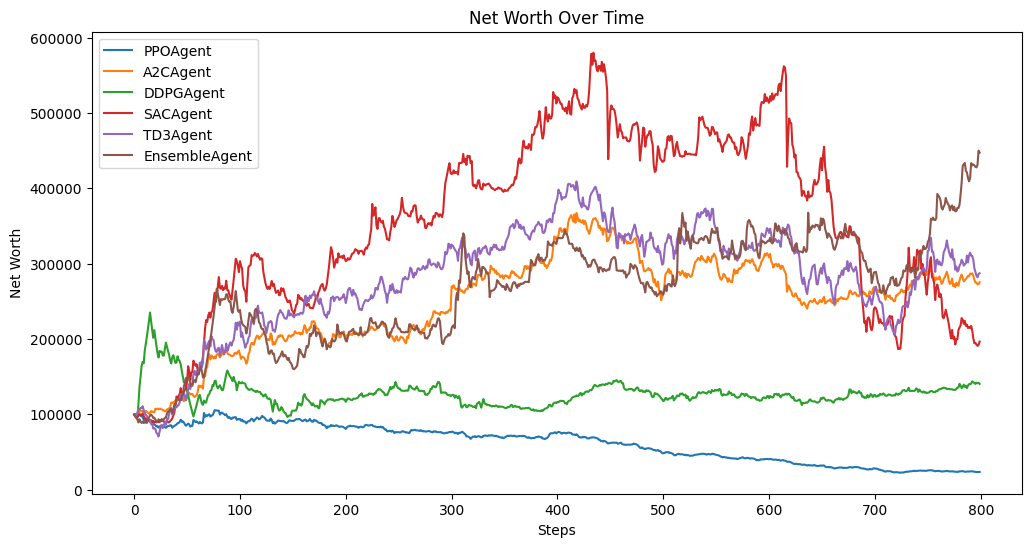

In [ ]:
test_metrics=test_and_visualize_agents(env, agents, training_data, n_tests = n_tests)


In [ ]:
agents_metrics = [
    test_metrics['PPOAgent'],
    test_metrics['A2CAgent'],
    test_metrics['DDPGAgent'],
    test_metrics['SACAgent'],
    test_metrics['TD3Agent'],
    test_metrics['EnsembleAgent']
]

In [ ]:
def compare_and_plot_agents_with_returns_1(agents_metrics, labels, risk_free_rate=0.0):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    returns = []
    stds = []
    sharpe_ratios = []

    daily_returns_all = []
    monthly_returns_all = []
    net_worths_all = []

    steps_per_month = 21  # Approximate trading days in a month

    for metrics in agents_metrics:
        net_worths = metrics['net_worths']
        net_worths_all.append(net_worths)

        # ----- Daily Returns -----
        daily_returns = np.diff(net_worths) / net_worths[:-1]
        daily_returns_all.append(daily_returns)

        # ----- Monthly Returns -----
        monthly_net_worths = net_worths[::steps_per_month]
        monthly_returns = np.diff(monthly_net_worths) / monthly_net_worths[:-1]
        monthly_returns_all.append(monthly_returns)

        # Use monthly returns for Sharpe Ratio
        avg_return = np.mean(monthly_returns)
        std_return = np.std(monthly_returns)
        sharpe_ratio = (avg_return/21 - risk_free_rate) / std_return

        returns.append(avg_return * 100)  # Monthly return in %
        stds.append(std_return)
        sharpe_ratios.append(sharpe_ratio)

    # ------------------ Comparison Table ------------------
    df = pd.DataFrame({
        'Agent': labels,
        'Monthly Returns (%)': returns,
        'Standard Deviation': stds,
        'Sharpe Ratio': sharpe_ratios
    })

    df_sorted = df.sort_values(by='Sharpe Ratio', ascending=False)
    display(df_sorted)

    # ------------------ Plot 1: Sharpe Ratio Bar ------------------
    plt.figure(figsize=(10, 5))
    plt.bar(df_sorted['Agent'], df_sorted['Sharpe Ratio'], color='darkcyan')
    plt.title('Sharpe Ratio Comparison (Monthly)')
    plt.xlabel('Agent')
    plt.ylabel('Sharpe Ratio')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # ------------------ Plot 2: Net Worth Over Time ------------------
    plt.figure(figsize=(12, 6))
    for net_worth, label in zip(net_worths_all, labels):
        plt.plot(net_worth, label=label)
    plt.title('Portfolio Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ------------------ Plot 3: Daily Returns Bar Plot ------------------
    avg_daily_returns = [np.mean(dr) * 100 for dr in daily_returns_all]  # In %
    plt.figure(figsize=(10, 5))
    plt.bar(labels, avg_daily_returns, color='darkcyan')
    plt.title('Average Daily Returns Comparison')
    plt.xlabel('Agent')
    plt.ylabel('Daily Return (%)')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # ------------------ Plot 4: Line Plot of Monthly Returns ------------------
    plt.figure(figsize=(12, 6))
    for returns, label in zip(monthly_returns_all, labels):
        plt.plot(returns * 21, label=label)
    plt.title("Monthly Returns Over Time")
    plt.xlabel("Month Index")
    plt.ylabel("Monthly Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ------------------ Plot 5: Scatter Plot of Monthly Returns ------------------
    plt.figure(figsize=(12, 6))
    for i, (returns, label) in enumerate(zip(monthly_returns_all, labels)):
        plt.scatter(range(len(returns)), returns, label=label, alpha=0.6, s=20)
    plt.title("Scatter Plot of Monthly Returns")
    plt.xlabel("Month Index")
    plt.ylabel("Monthly Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


,Agent,Monthly Returns (%),Standard Deviation,Sharpe Ratio
1,A2CAgent,3.031946,0.084710,0.017044
5,EnsembleAgent,5.189013,0.161872,0.015265
4,TD3Agent,3.728700,0.143270,0.012393
3,SACAgent,3.214550,0.177188,0.008639
2,DDPGAgent,2.096198,0.173858,0.005741
0,PPOAgent,-3.515787,0.063718,-0.026275


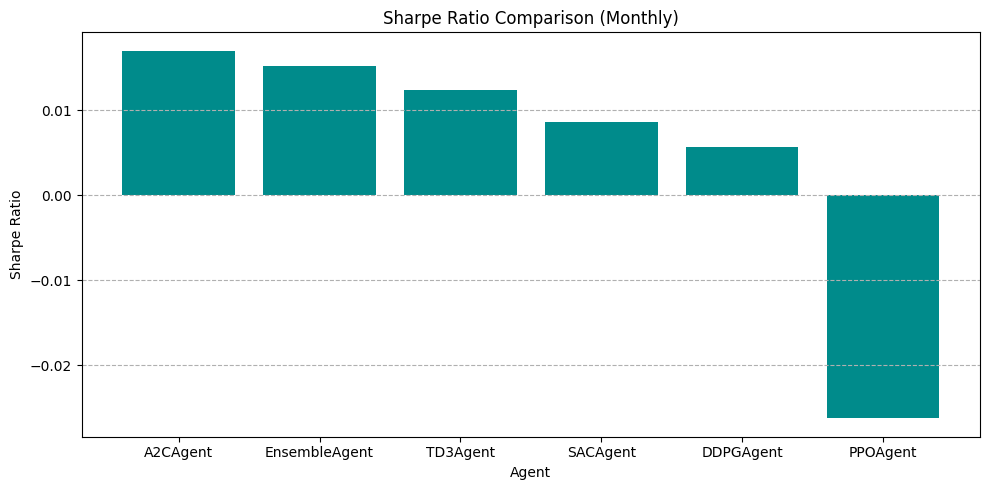

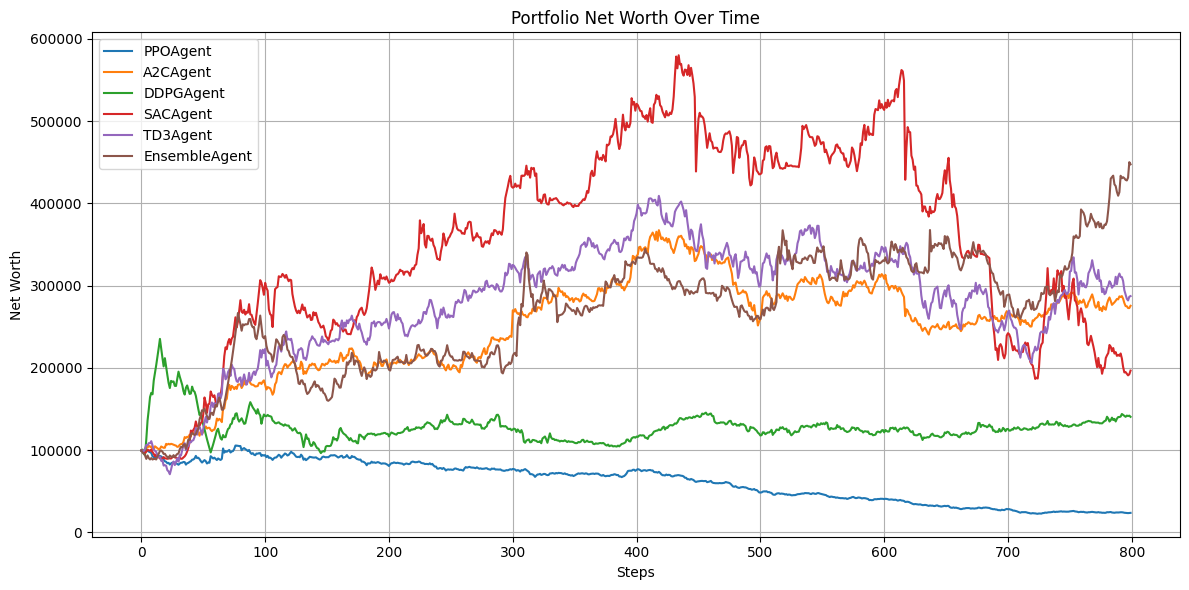

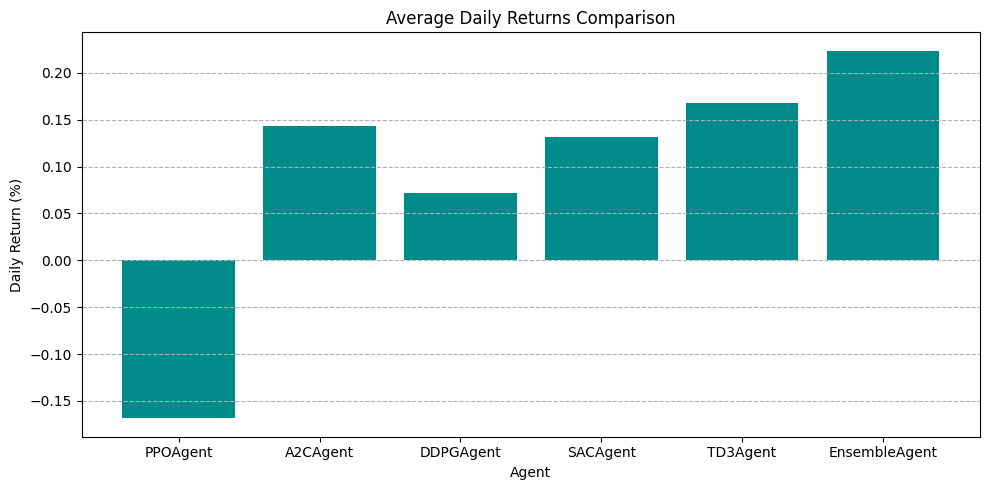

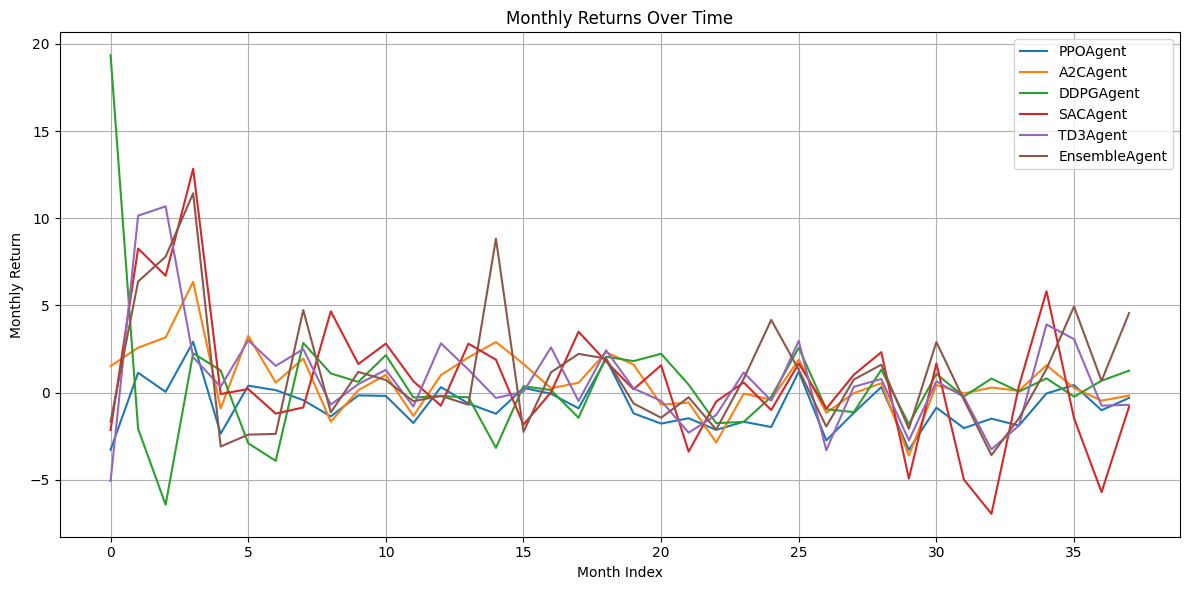

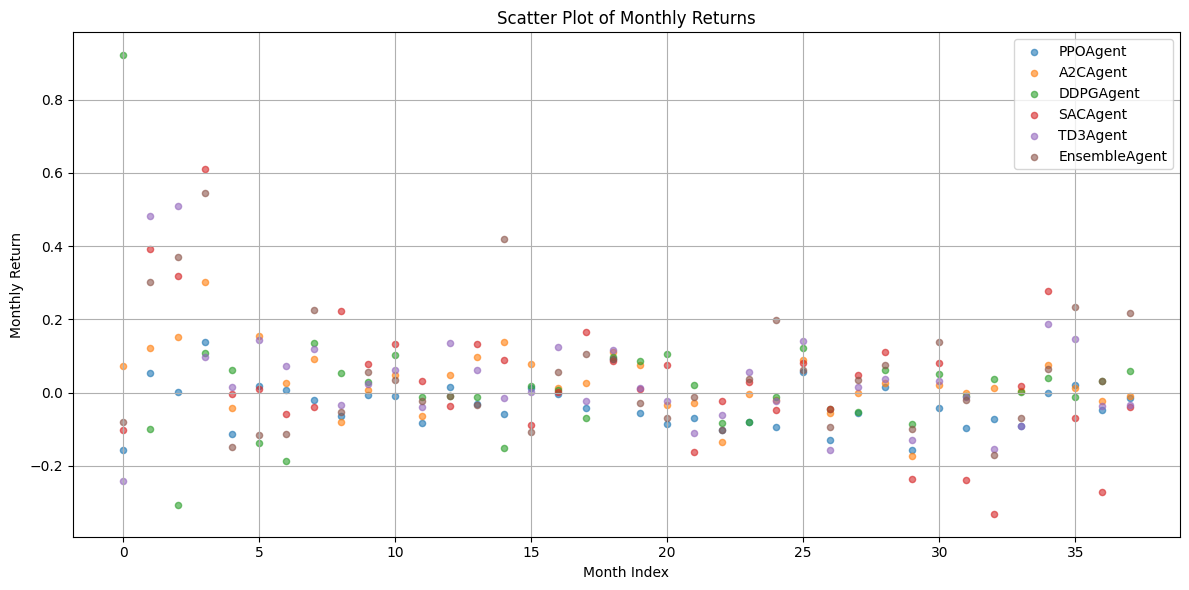

In [ ]:
compare_and_plot_agents_with_returns_1(agents_metrics, labels=['PPOAgent', 'A2CAgent', 'DDPGAgent', 'SACAgent','TD3Agent', 'EnsembleAgent'])